https://www.tensorflow.org/tutorials/audio/simple_audio?hl=ko

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
#미니 음성 데이터세트를 준비한다.
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 6s 0us/step


In [3]:
#데이터 세트의 각 음성은 8개의 카테고리:no , yes , down , go , left , up , right, stop에 해당하는 각각의 폴더에 저장되어 있습니다.
#data_dir안에있는 파일(폴더)의 리스트를 가져옵니다.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
#그중 'README.md'파일을 제외합니다.
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'no' 'left' 'stop' 'yes' 'down' 'go' 'right']


In [4]:
#모든 음성파일들을 filenames라는 목록으로 추출하여 섞습니다.
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/41285056_nohash_1.wav', shape=(), dtype=string)


In [5]:
#오디오 파일들을 8:1:1 비율로 훈련,검증,테스트세트로 나눕니다.

#filenames리스트를 처음부터 6400까지 슬라이스
train_files = filenames[:6400]
#filenames리스트를 6400부터 6400+800까지 슬라이스
val_files = filenames[6400: 6400 + 800]
#filenames리스트를 끝에서부터 역으로 800까지 슬라이스
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


# **오디오 파일 및 해당 레이블 읽기**
**데이터 wav파일을 디코딩하여 해당 텐서를 생성합니다.**

  -wav파일에는 초당 샘플수가 포함된 시계열 데이터가 포함되어있습니다.

  -각 샘플은 특정 시간의 오디오신호의 진폭을 나타냅니다.

  -미니 음성 명령 데이터 세트의 WAV 파일과 같은 16비트 시스템에서 진폭 값의 범위는 -32,768에서 32,767입니다.

  -속도는 16kHz입니다.

In [6]:
#tf.audio.decode_wav 가 반환하는 텐서의 모양은 [samples, channels] 입니다. 

test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')

#_는 텐서의 모양을 반환합니다.
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [7]:
#원시 wav파일을 오디오 텐서로 전환하는 함수
def decode_audio(audio_binary):
  # wav파일을 float32텐서로 전환하고 평준화합니다.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # 모든 데이터가 "mono"로 채널을 1개만 가지므로 텐서의 차원을 낮춥니다.
  return tf.squeeze(audio, axis=-1)

In [8]:
#각 파일의 상위 폴더의 이름을 사용하여 해당데이터의 라벨을 구하는 함수
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  #이때, 튜플 대신 임의의 리스트를 사용하려고 하면 텐서플로우에서 사용할 수 있게 언패킹 해주어야 합니다.
  return parts[-2]

In [9]:
#앞서 만든 두 함수를 합칩니다.
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
#데이터 세트를 제작합니다.
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

#Dataset.map메서드는 Dataset을 map_func로 받은 함수로 매핑합니다.
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [11]:
#Dataset.map 예제
def test(x):
  return x+1,x+2

dataset = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
dataset = dataset.map(map_func=test)
list(dataset.as_numpy_iterator())

[(2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]

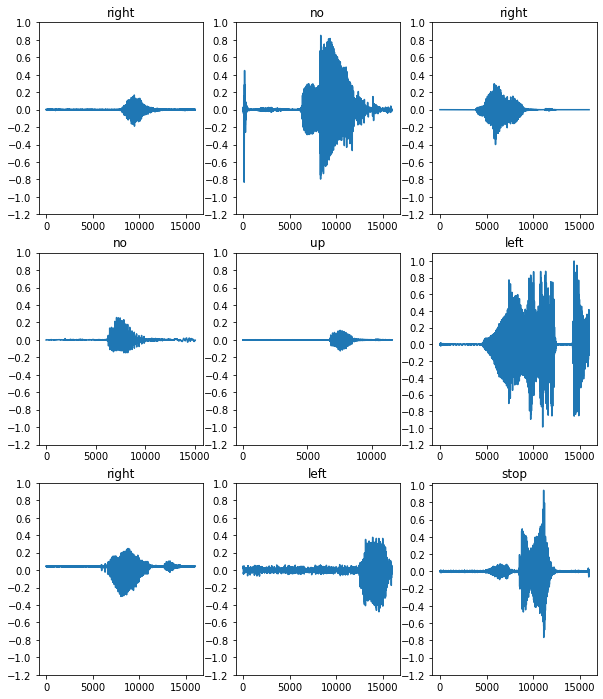

In [12]:
#오디오 샘플 파형 플로팅
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols #나누셈에서 몫을 구하는 연산자 //
  c = i % cols #나누셈에서 나머지를 구하는 연산자 %
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

**파형을 스펙트로그램으로 변환**

STFT(단기 푸리에 변환)을 사용하여 파형을 스펙트로그램으로 변환하여 신경망에 이미지처럼 공급할 수 있다.

**푸리에 변환( tf.signal.fft )은 신호를 구성 요소 주파수로 변환하지만 모든 시간 정보는 손실됩니다. 이에 비해 STFT( tf.signal.stft )는 신호를 시간 창으로 분할하고 각 창에서 푸리에 변환을 실행하여 일부 시간 정보를 보존하고 표준 컨볼루션을 실행할 수 있는 2D 텐서를 반환합니다.*


1.파형의 길이가 같아야 스펙트로그램으로 변환할 때 결과가 비슷한 차원을 갖게 되므로 1초보다 짧은 오디오 클립을 제로 패딩( tf.zeros 사용).

2.tf.signal.stft 를 호출할 때 생성된 스펙트로그램 이미지가 거의 정사각형이 되도록 frame_length 및 frame_step 매개변수를 설정.*(https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe)*

3.STFT는 크기와 위상을 나타내는 복소수 배열을 생성합니다. 그러나 이 자습서에서는 tf.abs 의 출력에 tf.signal.stft 를 적용하여 파생할 수 있는 크기만 사용합니다.

In [13]:
def get_spectrogram(waveform):
  # 16000보다 짧은 샘플수를 가지는 waveform을 제로패딩
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # wavefrom의 텐서 데이터형을 float32로 변환
  waveform = tf.cast(waveform, dtype=tf.float32)
  # wavefrom을 모든 오디오 정보를 담는 제로패딩으로 패딩
  # 이렇게하면 모든 클립의 길이가 같아진다..
  equal_length = tf.concat([waveform, zero_padding], 0)
  # STFT로 wavefrom을 스펙트로그램으로 변환
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # STFT의 크기를 구한다.
  spectrogram = tf.abs(spectrogram)
  # 스펙트로그램을 학습에 이용할 수 있게 차원 하나를 추가한다.
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
#wavefrom에서 샘플 하나를 가져와 스펙트로그램으로 변환
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
#오디오 재생
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [16]:
#스펙트로그램을 출력해주는 함수
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

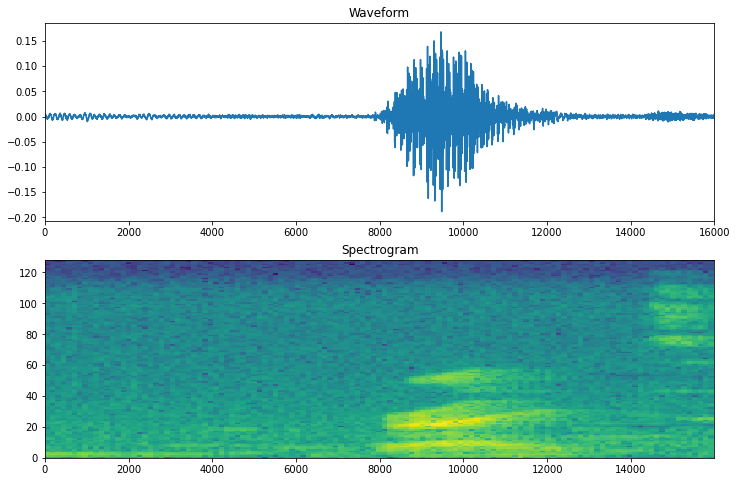

In [17]:
#파형과 스펙트로그램을 플로팅
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [18]:
#파형 데이터세트를 스펙트로그램으로 변환하는 함수 작성
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [19]:
#앞서 만든 함수를 waveform 데이터 세트에 매핑
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

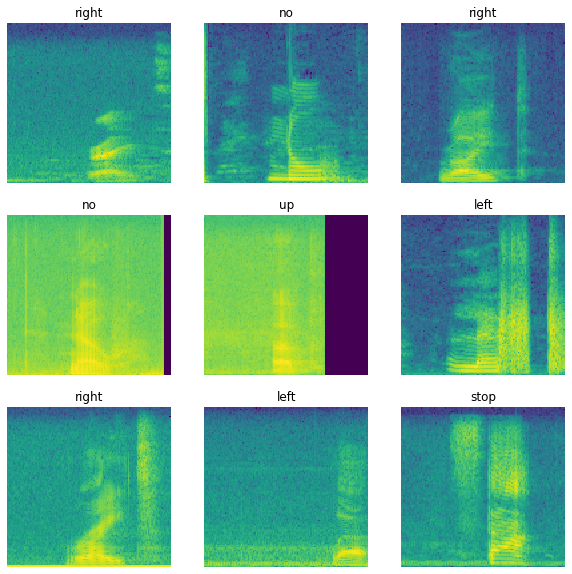

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()
#성공적인 변환을 볼 수 있다.

# 모델 빌드 및 학습

In [21]:
#데이터 세트 전처리 함수 작성
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
#검증세트와 테스트세트도 똑같이 전처리
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
#Dataset.cache 및 Dataset.prefetch 작업을 추가하여 모델을 훈련하는 동안 읽기 지연 시간을 줄입니다.
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

**이 모델의 경우 오디오 파일을 스펙트로그램 이미지로 변환했으므로 간단한 CNN을 사용합니다.**

tf.keras.layers.Resizing : 모델이 더 빠르게 학습할 수 있도록 입력을 다운샘플링합니다.

tf.keras.layers.Normalization : 평균과 표준편차를 기반으로 이미지의 각 픽셀을 정규화합니다.

In [27]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [28]:
#모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [29]:
#시험삼아 10에포크만 훈련
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 51s 497ms/step - loss: 1.7284 - accuracy: 0.3816 - val_loss: 1.2473 - val_accuracy: 0.6000
Epoch 2/10
100/100 [==============================] - 22s 219ms/step - loss: 1.1709 - accuracy: 0.5811 - val_loss: 0.8896 - val_accuracy: 0.7025
Epoch 3/10
100/100 [==============================] - 22s 217ms/step - loss: 0.9140 - accuracy: 0.6733 - val_loss: 0.7423 - val_accuracy: 0.7600
Epoch 4/10
100/100 [==============================] - 22s 217ms/step - loss: 0.7405 - accuracy: 0.7412 - val_loss: 0.7428 - val_accuracy: 0.7412
Epoch 5/10
100/100 [==============================] - 22s 215ms/step - loss: 0.6511 - accuracy: 0.7717 - val_loss: 0.6248 - val_accuracy: 0.7862
Epoch 6/10
100/100 [==============================] - 22s 217ms/step - loss: 0.5762 - accuracy: 0.7927 - val_loss: 0.5670 - val_accuracy: 0.8050
Epoch 7/10
100/100 [==============================] - 22s 217ms/step - loss: 0.4923 - accuracy: 0.8286 - val_loss: 0.5399 - val_ac

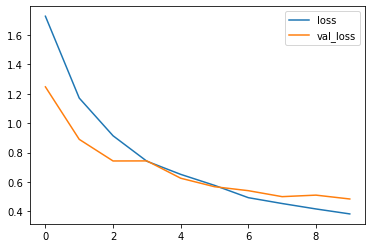

In [30]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
#학습 및 검증 손실 곡선을 플롯하여 학습 중에 모델이 어떻게 개선되었는지 확인하겠습니다.

# 모델 성능 평가

In [31]:
#테스트 세트에서 모델을 실행하고 모델을 평가
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [32]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 81%


**정오 분류표 표시**

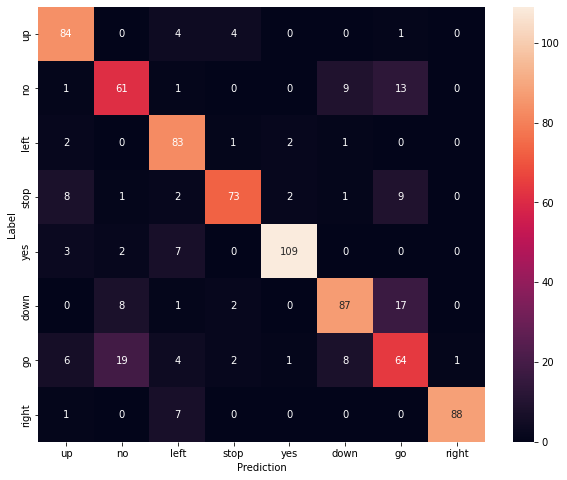

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# 오디오 파일에 대한 추론 실행

마지막으로 "no"음성 파일에 대한 추론을 실행해보겠습니다.

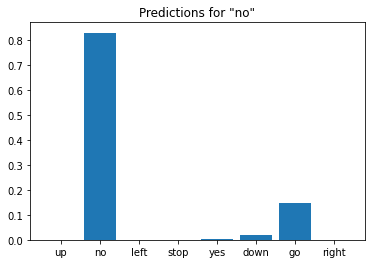

In [34]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()
  #정상적으로 "no"로 인식하는 것을 알 수 있다.